# Treinamento e implantação com Keras CNN no SageMaker

Baseado em https://aws.amazon.com/blogs/machine-learning/train-and-deploy-keras-models-with-tensorflow-and-apache-mxnet-on-amazon-sagemaker/

Modificamos nosso exemplo Keras MNIST do exercício anterior no script mnist-train-cnn.py que você deve carregar no diretório deste Notebook. É o mesmo código do exercício anterior, mas com um pouco de conteúdo extra para permitir que os hiperparâmetros sejam passados como argumentos do SageMaker.

In [1]:
import sagemaker
#criamos seção e execução do sagemaker
sess = sagemaker.Session()
role = sagemaker.get_execution_role()

## Salve o conjunto de dados MNIST no disco
para podermos fazer upload no S3

In [2]:
import os
import keras
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_val, y_val) = mnist.load_data()

#cria-se estrutura de diretórios, salva dados de treino e teste
os.makedirs("./data", exist_ok = True)

np.savez('./data/training', image=x_train, label=y_train)
np.savez('./data/validation', image=x_val, label=y_val)

Using TensorFlow backend.



11493376/11490434 [==============================] - 0s 0us/step


## Carregar dados MNIST para S3

Observe que sess.upload_data cria automaticamente um bucket S3 que atende aos critérios de segurança de começar com "sagemaker-".

In [3]:
prefix = 'keras-mnist'

training_input_path   = sess.upload_data('data/training.npz', key_prefix=prefix+'/training')
validation_input_path = sess.upload_data('data/validation.npz', key_prefix=prefix+'/validation')

print(training_input_path)
print(validation_input_path)

s3://sagemaker-us-east-1-358472144000/keras-mnist/training/training.npz
s3://sagemaker-us-east-1-358472144000/keras-mnist/validation/validation.npz


## Teste nosso script de treinamento CNN localmente na instância do notebook

Testaremos a execução de uma única epoch, apenas para garantir que o script funcione antes de começarmos a gastar dinheiro para treiná-lo posteriormente.
Mesma CNN usada anteriormente, porém adicionamos código para tratar hiperparâmetros de acordo com o Sagemaker e salvar o modelo

In [4]:
!pygmentize mnist-train-cnn.py

import argparse, os
import numpy as np

import tensorflow

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import multi_gpu_model

if __name__ == '__main__':

    parser = argparse.ArgumentParser()

    parser.add_argument('--epochs', type=int, default=10)
    parser.add_argument('--learning-rate', type=float, default=0.001)
    parser.add_argument('--batch-size', type=int, default=32)
    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--validation', type=str, default=os.environ['SM_CHANNEL_VALIDATION'])

    args, _ = parser.parse_

In [5]:
#agora rodamos o script anterior com apenas 1 epoch
from sagemaker.tensorflow import TensorFlow

tf_estimator = TensorFlow(entry_point='mnist-train-cnn.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='local',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={'epochs': 1}
                         )

In [6]:
#iniciar o treino de fato
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

Creating d0uhfi5xip-algo-1-kfzly ... 
Creating d0uhfi5xip-algo-1-kfzly ... done
Attaching to d0uhfi5xip-algo-1-kfzly
d0uhfi5xip-algo-1-kfzly | 2021-07-07 16:04:15,076 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
d0uhfi5xip-algo-1-kfzly | 2021-07-07 16:04:15,082 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
d0uhfi5xip-algo-1-kfzly | 2021-07-07 16:04:15,288 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
d0uhfi5xip-algo-1-kfzly | 2021-07-07 16:04:15,307 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
d0uhfi5xip-algo-1-kfzly | 2021-07-07 16:04:15,321 sagemaker-containers INFO     Invoking user script
d0uhfi5xip-algo-1-kfzly | 
d0uhfi5xip-algo-1-kfzly | Training Env:
d0uhfi5xip-algo-1-kfzly | 
d0uhfi5xip-algo-1-kfzly | {
d0uhfi5xip-algo-1-kfzly |     "additional_framework_parameters": {},
d0uhfi5xip-algo-1-kfzly |     "channel_input_dirs": {
d0uhfi5xip-algo-1

## Treine em uma instância de GPU com 10 épocas

Agora que temos certeza de que funciona, podemos começar a gastar dinheiro em servidores mais robustos para treinar nossa CNN por mais epochs.

In [9]:
tf_estimator = TensorFlow(entry_point='mnist-train-cnn.py', 
                          role=role,
                          instance_count=1, 
                          #instance_type='ml.p3.2xlarge',
                          #instance_type='local',
                          instance_type='ml.c5.2xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters={
                              'epochs': 10,
                              'batch-size': 32,
                              'learning-rate': 0.001}
                         )

In [10]:
tf_estimator.fit({'training': training_input_path, 'validation': validation_input_path})

2021-07-07 16:09:55 Starting - Starting the training job...
2021-07-07 16:10:19 Starting - Launching requested ML instancesProfilerReport-1625674195: InProgress
......
2021-07-07 16:11:19 Starting - Preparing the instances for training.........
2021-07-07 16:12:43 Downloading - Downloading input data
2021-07-07 16:12:43 Training - Downloading the training image..2021-07-07 16:13:02,443 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-07-07 16:13:02,447 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-07 16:13:02,755 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-07 16:13:02,769 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2021-07-07 16:13:02,778 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
    

## Implante o modelo
Para manter os custos baixos, podemos implantar nosso modelo em uma instância menor para fazer inferências. Você também pode usar instâncias de GPU, que seriam mais rápidas, mas com custo mais alto. Observe que também estamos usando um acelerador de inferência elástica aqui.

In [12]:
import time

tf_endpoint_name = 'keras-tf-mnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.c5.large',        
                         #accelerator_type='ml.eia1.medium',  
                         endpoint_name=tf_endpoint_name)     

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

## Faça previsões com o modelo implantado
5 imagens

Predicted labels are: [9 1 0 2 8]


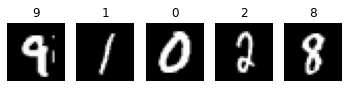

In [15]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

## Limpe o endpoint de implantação

In [16]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name)

## Encontre os melhores hiperparâmetros com o ajuste automático de modelo
Esta é de longe a parte mais cara deste exercício; vamos usar uma boa quantidade de tempo em instâncias P3 aqui. Se você está preocupado com seus custos de AWS, pule o resto deste notebook e apenas desligue sua instância de notebook SageMaker agora.

In [17]:
tf_estimator = TensorFlow(entry_point='mnist-train-cnn.py', 
                          role=role,
                          instance_count=1, 
                          instance_type='ml.c5.2xlarge',
                          #instance_type='ml.p3.2xlarge',
                          framework_version='1.12', 
                          py_version='py3',
                          script_mode=True
                         )

In [18]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    'epochs':        IntegerParameter(5, 20),
    'learning-rate': ContinuousParameter(0.0001, 0.1, scaling_type='Logarithmic'), 
    'batch-size':    IntegerParameter(32, 1024),
}

objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc', 'Regex': 'val_acc: ([0-9\\.]+)'}]

#máximo de 10 jobs
#máximo 2 paralelos
tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=10,
                            max_parallel_jobs=2,
                            objective_type=objective_type)

In [19]:
#podemos ver a execução em  hyperparameter tunning jobs
tuner.fit({'training': training_input_path, 'validation': validation_input_path})

............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


## Implante o melhor modelo

In [20]:
import time

tf_endpoint_name = 'keras-tf-mnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tuner.deploy(initial_instance_count=1,
                         instance_type='ml.c5.2xlarge',       
                         #accelerator_type='ml.eia1.medium',
                         endpoint_name=tf_endpoint_name)


2021-07-07 17:13:24 Starting - Preparing the instances for training
2021-07-07 17:13:24 Downloading - Downloading input data
2021-07-07 17:13:24 Training - Training image download completed. Training in progress.
2021-07-07 17:13:24 Uploading - Uploading generated training model
2021-07-07 17:13:24 Completed - Training job completed

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



---------------!

## Preveja novamente

Predicted labels are: [0 3 0 8 7]


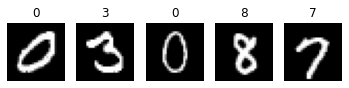

In [22]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

num_samples = 5
indices = random.sample(range(x_val.shape[0] - 1), num_samples)
images = x_val[indices]/255
labels = y_val[indices]

for i in range(num_samples):
    plt.subplot(1,num_samples,i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
    
prediction = tf_predictor.predict(images.reshape(num_samples, 28, 28, 1))['predictions']
prediction = np.array(prediction)
predicted_label = prediction.argmax(axis=1)
print('Predicted labels are: {}'.format(predicted_label))

## Limpar

In [23]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name)

## Lembre-se de desligar a instância do seu notebook também!